In [20]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

# ================= 实验控制面板 (Control Panel) =================
# 每次跑实验前，只需要改这里的参数，然后保存运行即可！

# 1. 特征选择开关
USE_TOP_10_ONLY = True   # 【实验1开关】设为 True 就是只用Top10，设为 False 就是用全量数据

# 2. 模型参数调整
WINDOW_SIZE = 10        # 【实验2参数】回顾过去多少天？(比如改成 20)
LGBM_LEAVES = 256        # 【实验3参数】最大叶子数 (比如改成 128)
LEARNING_RATE = 0.05     # 【实验3参数】学习率 (比如改成 0.05)

# 3. 固定参数 (通常不用变)
FILE_PATH = 'C:/Users/HUAWEI/Desktop/LSTM/train.csv'
EPOCHS = 100             # 对LGBM来说是迭代轮数
# ==============================================================

In [21]:
def create_lgbm_features(df, window_size):
    """
    为LGBM创建时间序列特征
    """
    # 复制数据避免修改原数据
    df_featured = df.copy()
    
    # 为每个数值特征创建滞后特征
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # 移除目标列
    if 'forward_returns' in numeric_cols:
        numeric_cols.remove('forward_returns')
    if 'market_forward_excess_returns' in numeric_cols:
        numeric_cols.remove('market_forward_excess_returns')
    
    # 创建滞后特征
    for col in numeric_cols:
        for lag in range(1, window_size + 1):
            df_featured[f'{col}_lag_{lag}'] = df_featured[col].shift(lag)
    
    # 创建滚动统计特征
    for col in numeric_cols:
        df_featured[f'{col}_rolling_mean_{window_size}'] = df_featured[col].rolling(window=window_size).mean()
        df_featured[f'{col}_rolling_std_{window_size}'] = df_featured[col].rolling(window=window_size).std()
        df_featured[f'{col}_rolling_max_{window_size}'] = df_featured[col].rolling(window=window_size).max()
        df_featured[f'{col}_rolling_min_{window_size}'] = df_featured[col].rolling(window=window_size).min()
    
    # 删除包含NaN的行（由于滞后和滚动窗口产生）
    df_featured = df_featured.dropna()
    
    return df_featured

>>> LightGBM 模型启动：正在构建梯度提升树模型...
★ 实验模式：开启！仅使用 Top 10 特征进行训练
正在创建时间序列特征 (窗口大小: 10)...


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_21080\2790072224.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featured[f'{col}_lag_{lag}'] = df_featured[col].shift(lag)
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_21080\2790072224.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featured[f'{col}_rolling_mean_{window_size}'] = df_featured[col].rolling(window=window_size).mean()
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_21080\2790072224.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

特征数量: 150
训练集大小: 4635, 验证集大小: 1159

[Model] 正在准备LightGBM数据...

[Training] 开始训练LightGBM...
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 0.000106055

[Prediction] 正在生成预测结果...
预测完成！前10个预测权重: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
模型已保存为 my_lgbm_model.csv

★ LightGBM 模型评估 ★
方向命中率 (Hit Rate): 54.87%
MSE: 0.000106

Top 10 重要特征:
  feature  importance
       M4          23
V13_lag_1          19
 M2_lag_4          17
 M4_lag_1          16
       M2          15
 M4_lag_2          15
 S5_lag_4          13
       V7          13
       S5          12
 M4_lag_6          12
-> 已保存高清图表: lgbm_report_plot.png


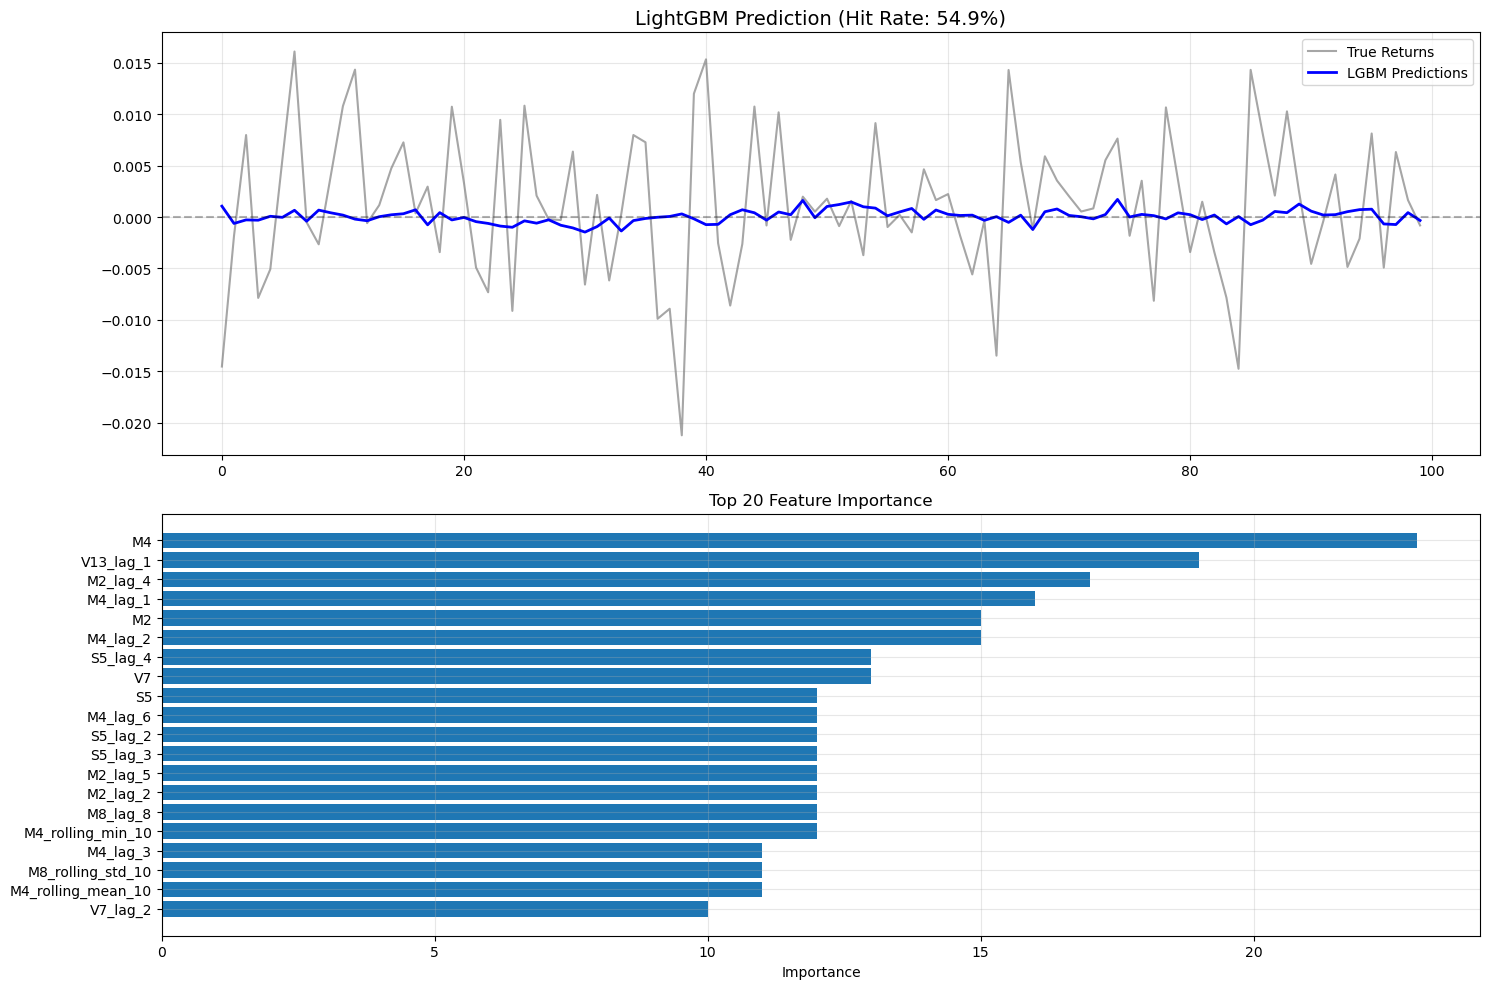

In [23]:
def run_lgbm():
    print("="*50)
    print(">>> LightGBM 模型启动：正在构建梯度提升树模型...")
    print("="*50)

    # 1. 加载数据
    if not os.path.exists(FILE_PATH):
        print(f"错误：找不到 {FILE_PATH}，请检查路径。")
        return
    
    df = pd.read_csv(FILE_PATH)
    
    # 按时间排序
    if 'date_id' in df.columns:
        df = df.sort_values('date_id')
        dates = df['date_id'].copy()  # 保存日期用于后续分析
        df = df.drop(columns=['date_id'])

    # === 特征选择 ===
    target_col = 'forward_returns'
    
    if USE_TOP_10_ONLY:
        print(f"★ 实验模式：开启！仅使用 Top 10 特征进行训练")
        top_features = ['M4', 'V13', 'S5', 'S2', 'V7', 'M2', 'M17', 'M12', 'M8', 'S6']
        required_cols = top_features + [target_col]
        df = df[required_cols]
    else:
        print(f"★ 实验模式：使用全量特征进行训练")

    # 删除未来数据
    drop_cols = ['market_forward_excess_returns']
    drop_cols = [c for c in drop_cols if c in df.columns]
    df = df.drop(columns=drop_cols)

    # 2. 创建时间序列特征
    print(f"正在创建时间序列特征 (窗口大小: {WINDOW_SIZE})...")
    df_featured = create_lgbm_features(df, WINDOW_SIZE)
    
    # 分离特征和目标
    feature_cols = [col for col in df_featured.columns if col != target_col]
    X = df_featured[feature_cols]
    y = df_featured[target_col]
    
    print(f"特征数量: {X.shape[1]}")

    # 3. 时间序列分割 (严禁shuffle!)
    split_idx = int(len(X) * 0.8)
    
    X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]
    
    print(f"训练集大小: {len(X_train)}, 验证集大小: {len(X_val)}")

    # 4. 创建LightGBM数据集
    print("\n[Model] 正在准备LightGBM数据...")
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # 5. 设置LGBM参数
    params = {
        'objective': 'regression',
        'metric': 'mse',
        'num_leaves': LGBM_LEAVES,
        'learning_rate': LEARNING_RATE,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'seed': 42
    }

    # 6. 训练模型
    print("\n[Training] 开始训练LightGBM...")
    model = lgb.train(
        params,
        train_data,
        num_boost_round=EPOCHS,
        valid_sets=[val_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=10, verbose=True),
            lgb.log_evaluation(50)  # 每50轮输出一次日志
        ]
    )

    # 7. 预测和策略转换
    print("\n[Prediction] 正在生成预测结果...")
    predictions = model.predict(X_val)
    
    # 策略逻辑 (与LSTM版本保持一致)
    predicted_weights = []
    for pred in predictions:
        if pred > 0.001:  # 预测涨幅超过 0.1%
            weight = 1.0
        elif pred > 0.005: # 预测涨幅超过 0.5%
            weight = 2.0
        else:
            weight = 0.0
        predicted_weights.append(weight)
        
    print("预测完成！前10个预测权重:", predicted_weights[:10])
    
    # 保存模型
    model.save_model('my_lgbm_model.txt')
    print("模型已保存为 my_lgbm_model.txt")

    # 8. 评估模块
    # --- 计算方向命中率 ---
    true_direction = y_val > 0
    pred_direction = predictions > 0
    hit_rate = accuracy_score(true_direction, pred_direction)
    
    # --- 特征重要性分析 ---
    feature_importance = pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance()
    }).sort_values('importance', ascending=False)
    
    print("\n" + "="*50)
    print(f"★ LightGBM 模型评估 ★")
    print(f"方向命中率 (Hit Rate): {hit_rate * 100:.2f}%")
    print(f"MSE: {mean_squared_error(y_val, predictions):.6f}")
    print("\nTop 10 重要特征:")
    print(feature_importance.head(10).to_string(index=False))
    print("="*50)

    # 9. 可视化结果
    plt.figure(figsize=(15, 10))
    
    # 子图1: 预测 vs 真实值
    plt.subplot(2, 1, 1)
    plt.plot(y_val.values[:100], label='True Returns', color='gray', alpha=0.7)
    plt.plot(predictions[:100], label='LGBM Predictions', color='blue', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    plt.title(f'LightGBM Prediction (Hit Rate: {hit_rate*100:.1f}%)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2: 特征重要性
    plt.subplot(2, 1, 2)
    top_20_features = feature_importance.head(20)
    plt.barh(range(len(top_20_features)), top_20_features['importance'])
    plt.yticks(range(len(top_20_features)), top_20_features['feature'])
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('lgbm_report_plot.png', dpi=300)
    print("-> 已保存高清图表: lgbm_report_plot.png")
    plt.show()

if __name__ == "__main__":
    run_lgbm()